In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import zipfile
from PIL import Image

#PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/archive.zip'
extract_folder = '/content/data_dir'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

Mounted at /content/drive


Hyper Parameters

In [3]:
BATCH_SIZE = 128
EPOCHS = 25
LEARNING_RATE = 0.001
RANDOM_STATE = 42
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"
criterion = nn.CrossEntropyLoss()
METRICS = [
    "accuracy",
    "precision",
    "recall"
]
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

losses = {'train': [], 'val': []}
accuracies = {'train': [], 'val': []}
f1_scores = {'train': [], 'val': []}

Data


<center>
<img src="https://i.pinimg.com/originals/cd/5f/c4/cd5fc4478e62ab5ca0bfe091fdb58a50.gif" alt="error" width="400" height="200"></center>


In [4]:
!wget -O crop_metadata.csv https://data.pawsey.org.au/download/FDFML/metadata/crop_metadata.csv
df_meta = pd.read_csv("/content/crop_metadata.csv")
df_meta.fillna("", inplace=True)
df_meta.head()
print("Total video crop frames (unique):", df_meta.file_name.nunique())
print("Total Fish Objects (Bounding Boxes):", df_meta.shape[0])
print("Total Fish Family:", df_meta.family.nunique())
print("Total Fish Genus:", df_meta.genus.nunique())
print("Total Fish Species:", df_meta.species.nunique())

--2024-05-25 06:37:35--  https://data.pawsey.org.au/download/FDFML/metadata/crop_metadata.csv
Resolving data.pawsey.org.au (data.pawsey.org.au)... 146.118.114.110
Connecting to data.pawsey.org.au (data.pawsey.org.au)|146.118.114.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6414083 (6.1M) [text/csv]
Saving to: ‘crop_metadata.csv’

crop_metadata.csv   100%[===================>]   6.12M  4.85MB/s    in 1.3s    

2024-05-25 06:37:37 (4.85 MB/s) - ‘crop_metadata.csv’ saved [6414083/6414083]

Total video crop frames (unique): 80823
Total Fish Objects (Bounding Boxes): 80823
Total Fish Family: 75
Total Fish Genus: 215
Total Fish Species: 497


Data processing

## Load pre-trained models

### DenseNet

In [5]:
densenet121 = torchvision.models.densenet121(pretrained=True)
## without those line the weight are trained from start
## and the weight of the saved model from earlier data sets changes. there is no transfer learning.
## if trandsfer learning is needed : addthose lines and change the train to change the gardient in some layers.
for param in densenet121.parameters():
    param.requires_grad=False

densenet121.classifier = nn.Linear(in_features=densenet121.classifier.in_features, out_features=104, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 82.2MB/s]


### GoogleNet

In [6]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
    param.grad_requires = False

googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=104, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 204MB/s]


### ResNet101

In [7]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
    param.grad_requires = False

resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=104, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 217MB/s]


### ViT

In [8]:
ViT  = torchvision.models.vit_b_16(pretrained=True)
for param in ViT.parameters():
    param.requires_grad=False

ViT.heads.head = nn.Linear(ViT.heads.head.in_features, 104)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 183MB/s]


### VGG 19

In [9]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
    param.grad_requires = False

vgg19_bn.classifier[6] = nn.Linear(4096, 104, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 224MB/s]


### train and test

new try

## Transfer Learning Approach

In [10]:
df_meta = pd.read_csv("/content/crop_metadata.csv")
print(df_meta.columns)
df_meta['species'].fillna('Unknown', inplace=True)
print("Before cleanup, NaN counts in 'species':", df_meta['species'].isna().sum())
df_meta['species'] = df_meta['species'].astype(str)
print(df_meta.info())
unique_species = df_meta['species'].unique()
print({species: type(species) for species in unique_species})
df_meta['species'] = df_meta['species'].apply(lambda x: str(x))
print({species: type(species) for species in unique_species})
sorted_species = sorted(df_meta['species'].unique())

species_counts = df_meta['species'].value_counts()
print(species_counts)

# Get the top 20 most frequent species
top_species = species_counts.nlargest(20).index

# Filter the DataFrame to only include rows where the species is one of the top 12
df_meta = df_meta[df_meta['species'].isin(top_species)]

print(df_meta['species'].value_counts())  # To verify the filtering

Index(['uid', 'file_name', 'family', 'genus', 'species'], dtype='object')
Before cleanup, NaN counts in 'species': 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80823 entries, 0 to 80822
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uid        80823 non-null  int64 
 1   file_name  80823 non-null  object
 2   family     80809 non-null  object
 3   genus      80156 non-null  object
 4   species    80823 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.1+ MB
None
{'capistratoides': <class 'str'>, 'leucocheilus': <class 'str'>, 'reticulatus': <class 'str'>, 'fasciatus': <class 'str'>, 'pyroferus': <class 'str'>, 'scopas': <class 'str'>, 'digrammus': <class 'str'>, 'coelestis': <class 'str'>, 'weberi': <class 'str'>, 'multifasciatus': <class 'str'>, 'striatus': <class 'str'>, 'undulatus': <class 'str'>, 'chrysopterum': <class 'str'>, 'trimaculatus': <class 'str'>, 'viridescens': <class 'str'>, 'vlamingii

In [11]:
torch.cuda.empty_cache()
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load pre-trained models
models_list = [
    densenet121,
    googlenet,
    resnet101,
    vgg19_bn,
]


class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.metadata_frame = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.metadata_frame.dropna(subset=['species'], inplace=True)  # Drop any rows with NaN in 'species'
        self.metadata_frame.reset_index(drop=True, inplace=True)  # Reset index after dropping rows
        self.classes = sorted(self.metadata_frame['species'].unique())  # Sort the classes
    def __len__(self):
        return len(self.metadata_frame)


    def __getitem__(self, idx):
      file_name = self.metadata_frame.loc[idx, 'file_name']
      img_path = os.path.join(self.img_dir, file_name)
      image = Image.open(img_path).convert('RGB')
      label = self.metadata_frame.loc[idx, 'species']
      label = self.classes.index(label)  # Convert label name to index

      if self.transform:
          image = self.transform(image)

      return image, label

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create the dataset
img_dir = '/content/data_dir/FDFML/crops'
df_meta = pd.read_csv("/content/crop_metadata.csv")



species_counts = df_meta['species'].value_counts()

# Get the top 12 most frequent species
top_species = species_counts.nlargest(12).index

# Filter the DataFrame to only include rows where the species is one of the top 12
df_meta = df_meta[df_meta['species'].isin(top_species)]
print(df_meta['species'].value_counts())

dataset = CustomImageDataset(df_meta, img_dir, transform=data_transforms)



# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


# Modify the last layer for your classification task
num_classes = len(dataset.classes)
for model in models_list:
    if isinstance(model, models.ResNet):
        # For ResNet models
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif isinstance(model, models.VGG):
        # For VGG models
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes)
    elif isinstance(model, models.DenseNet):
        # For DenseNet models
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)
    elif isinstance(model, models.GoogLeNet):
        # For GoogLeNet models
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif isinstance(model, models.VisionTransformer):
        # For ViT models
        num_features = model.heads.head.in_features
        model.heads.head = nn.Linear(num_features, num_classes)
    model.to(device)

# Training function
def train(model, criterion, optimizer, data_loader):
    model.train()  # Set model to training mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # zero the parameter gradients

        # forward
        # track history if only in train
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
    return running_loss, running_corrects, epoch_f1

# Evaluation function
def eval(model, criterion, optimizer, data_loader):
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
    return running_loss, running_corrects, epoch_f1



# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    best_acc = 0.0

    # First step: Train only the classifier layers
    for param in model.parameters():
        param.requires_grad = False

    if isinstance(model, models.ResNet):
        for param in model.fc.parameters():
            param.requires_grad = True
    elif isinstance(model, models.VGG):
        for param in model.classifier[6].parameters():
            param.requires_grad = True
    elif isinstance(model, models.DenseNet):
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif isinstance(model, models.GoogLeNet):
        for param in model.fc.parameters():
            param.requires_grad = True
    elif isinstance(model, models.VisionTransformer):
        for param in model.head.parameters():
            param.requires_grad = True

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    print('Start of Classification Training!')
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss, running_corrects, epoch_f1 = train(model, criterion, optimizer, data_loader) if phase == 'train' else eval(model, criterion, optimizer, data_loader)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            f1_scores[phase].append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} f1 Score: {epoch_f1:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        if scheduler is not None:
            scheduler.step()

    #print('Epoch')
    # Second step: Fine-tune the entire model
    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    print('\nStart of Fine-Tuning!')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader

            running_loss, running_corrects, epoch_f1 = train(model, criterion, optimizer, data_loader) if phase == 'train' else eval(model, criterion, optimizer, data_loader)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            f1_scores[phase].append(epoch_f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1 Score: {epoch_f1:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        if scheduler is not None:
            scheduler.step()


    print(f'Best Val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# Training loop for each model

for model in models_list:
    print('=' * 40)
    print(f'Training {model.__class__.__name__}...')
    model = train_model(model, criterion, None, None, num_epochs=EPOCHS)
    # Save the best model
    model_name = model.__class__.__name__
    torch.save(model.state_dict(), f'{model_name}_best_model.pth')
    print(f'{model_name} saved.')
    print('=' * 25)
    print("\n")

species
punctulatus         6095
digramma            3172
atkinsoni           2635
sebae               2338
lutescens           2007
rubrioperculatus    1782
spp                 1730
niger               1728
lunare              1725
coelestis           1693
vitta               1597
temminckii          1256
Name: count, dtype: int64
Training DenseNet...
Start of Classification Training!
Epoch 1/25
----------
train Loss: 1.3530 Acc: 0.5729 f1 Score: 0.7000
val Loss: 0.9420 Acc: 0.6877 f1 Score: 0.7583
Epoch 2/25
----------
train Loss: 0.8990 Acc: 0.7054 f1 Score: 0.7575
val Loss: 0.8031 Acc: 0.7216 f1 Score: 0.7870
Epoch 3/25
----------
train Loss: 0.7939 Acc: 0.7362 f1 Score: 0.7444
val Loss: 0.7601 Acc: 0.7278 f1 Score: 0.7767
Epoch 4/25
----------
train Loss: 0.7394 Acc: 0.7510 f1 Score: 0.7577
val Loss: 0.7209 Acc: 0.7399 f1 Score: 0.7641
Epoch 5/25
----------
train Loss: 0.7018 Acc: 0.7624 f1 Score: 0.7697
val Loss: 0.6893 Acc: 0.7540 f1 Score: 0.8007
Epoch 6/25
----------
train Los

## **Test Function**

In [12]:
# Test function
def test_model(model, test_loader):
    with torch.no_grad():
        torch.cuda.empty_cache()
        model.eval()   # Set model to evaluate mode
        running_corrects = 0

        # Iterate over test data
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Update running corrects
            running_corrects += torch.sum(preds == labels.data)

        test_acc = running_corrects.double() / len(test_loader.dataset)
        test_f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
        print(f'Test Acc: {test_acc:.4f} Test f1 Score: {test_f1:.4f}')

        return test_acc, test_f1

# Test each trained model
for model in models_list:
    print(f'Testing {model.__class__.__name__}...')
    model_name = model.__class__.__name__
    # Check if the model architecture has changed
    if model.state_dict().keys() != torch.load(f'{model_name}_best_model.pth').keys():
        print(f'Model architecture has changed. Skipping {model_name}.')
        continue
    model.load_state_dict(torch.load(f'{model_name}_best_model.pth'))
    test_acc, test_f1 = test_model(model, test_loader)

Testing DenseNet...
Test Acc: 0.9515 Test f1 Score: 0.9525
Testing GoogLeNet...
Test Acc: 0.9441 Test f1 Score: 0.9540
Testing ResNet...
Test Acc: 0.9393 Test f1 Score: 0.9292
Testing VGG...
Test Acc: 0.9167 Test f1 Score: 0.9092


## Visualization


Sample of the data with labels, predictions, and correctness:

DenseNet121:


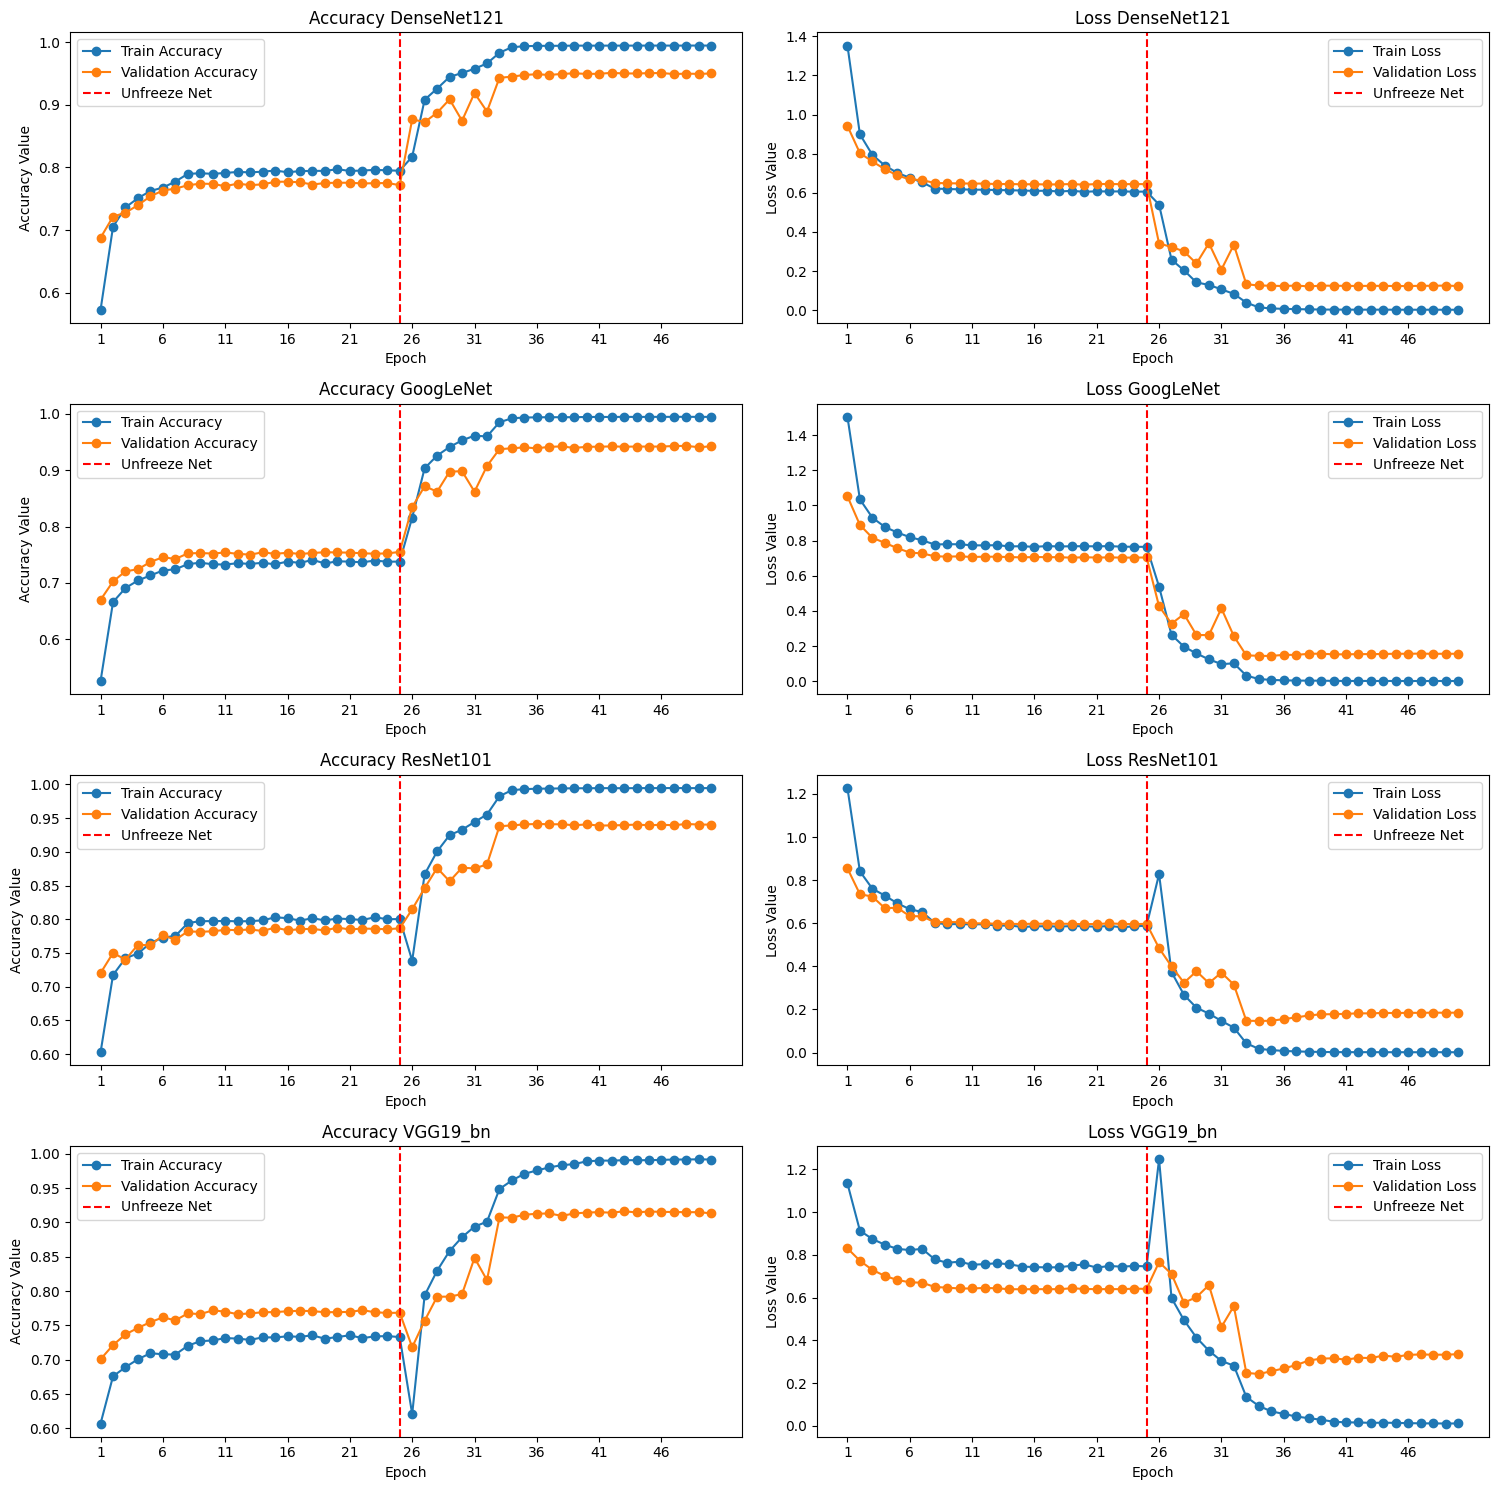

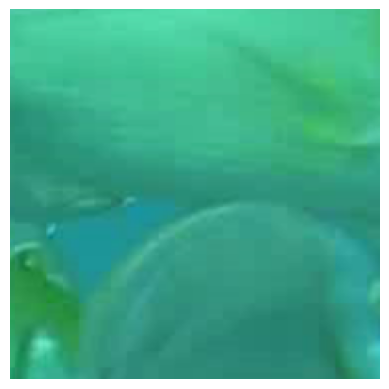

Sample 1:
Label: punctulatus
Prediction: punctulatus
Correctness: Correct


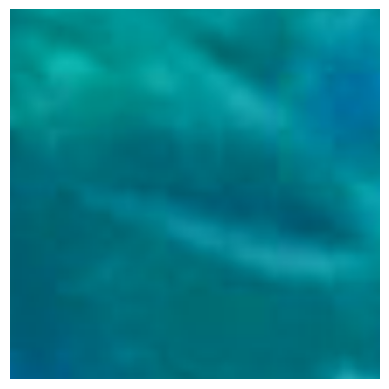

Sample 2:
Label: temminckii
Prediction: temminckii
Correctness: Correct


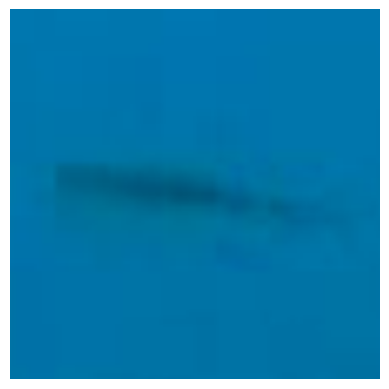

Sample 3:
Label: temminckii
Prediction: temminckii
Correctness: Correct


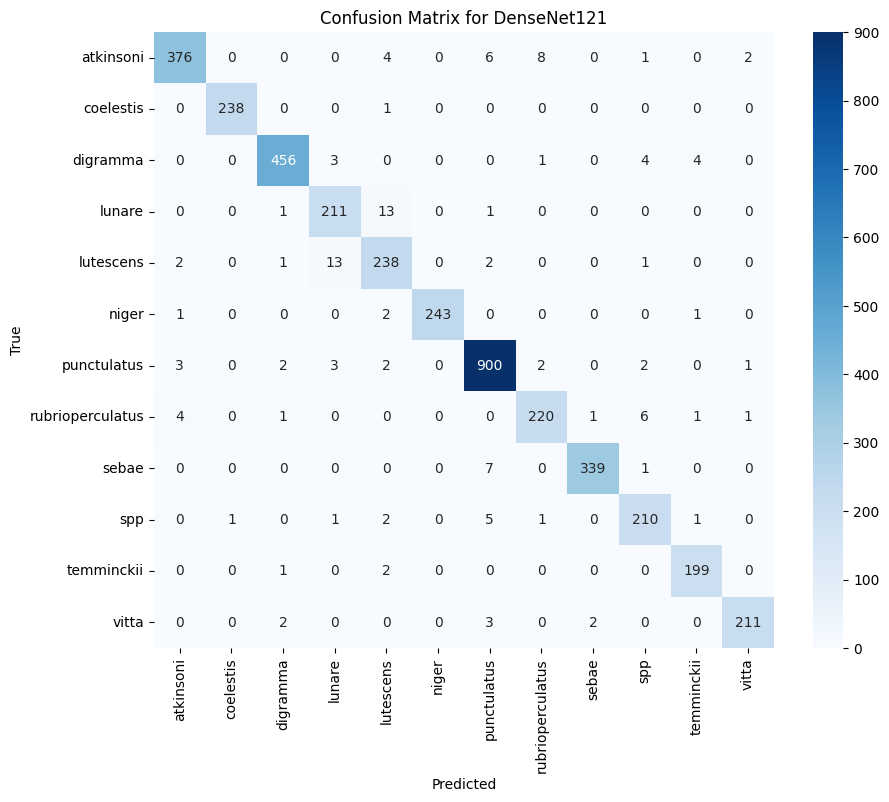


GoogLeNet:


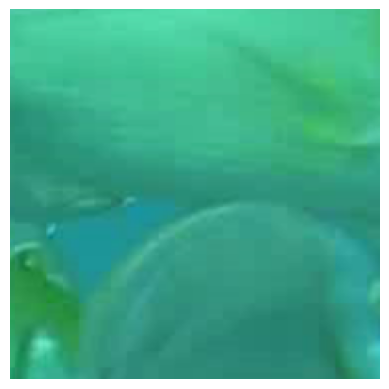

Sample 1:
Label: punctulatus
Prediction: punctulatus
Correctness: Correct


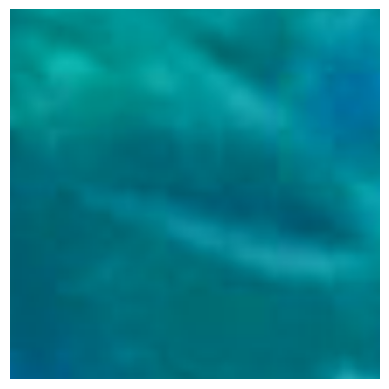

Sample 2:
Label: temminckii
Prediction: temminckii
Correctness: Correct


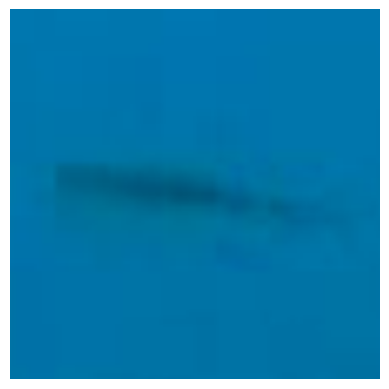

Sample 3:
Label: temminckii
Prediction: temminckii
Correctness: Correct


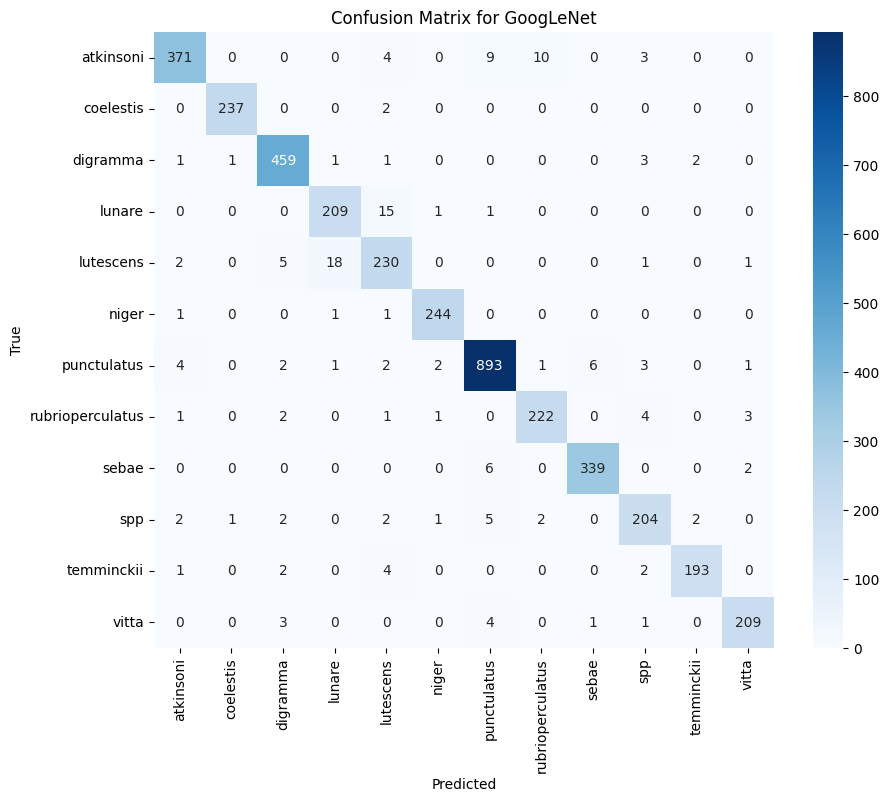


ResNet101:


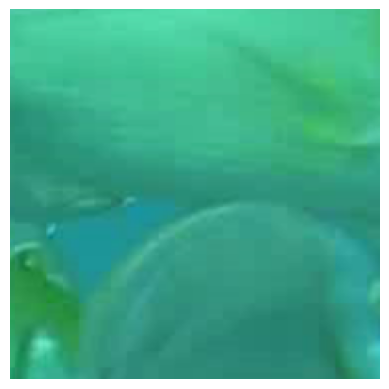

Sample 1:
Label: punctulatus
Prediction: punctulatus
Correctness: Correct


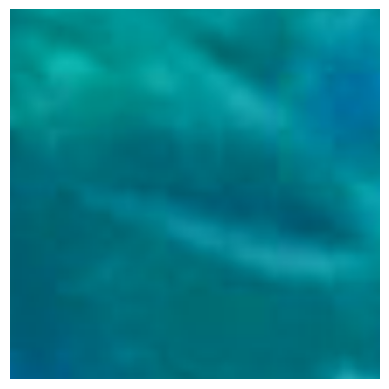

Sample 2:
Label: temminckii
Prediction: temminckii
Correctness: Correct


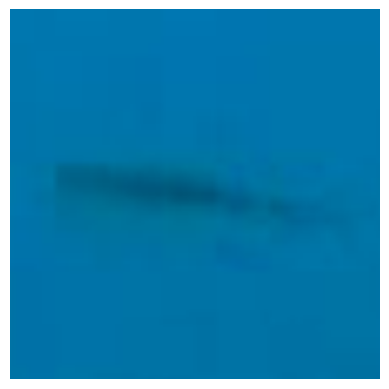

Sample 3:
Label: temminckii
Prediction: temminckii
Correctness: Correct


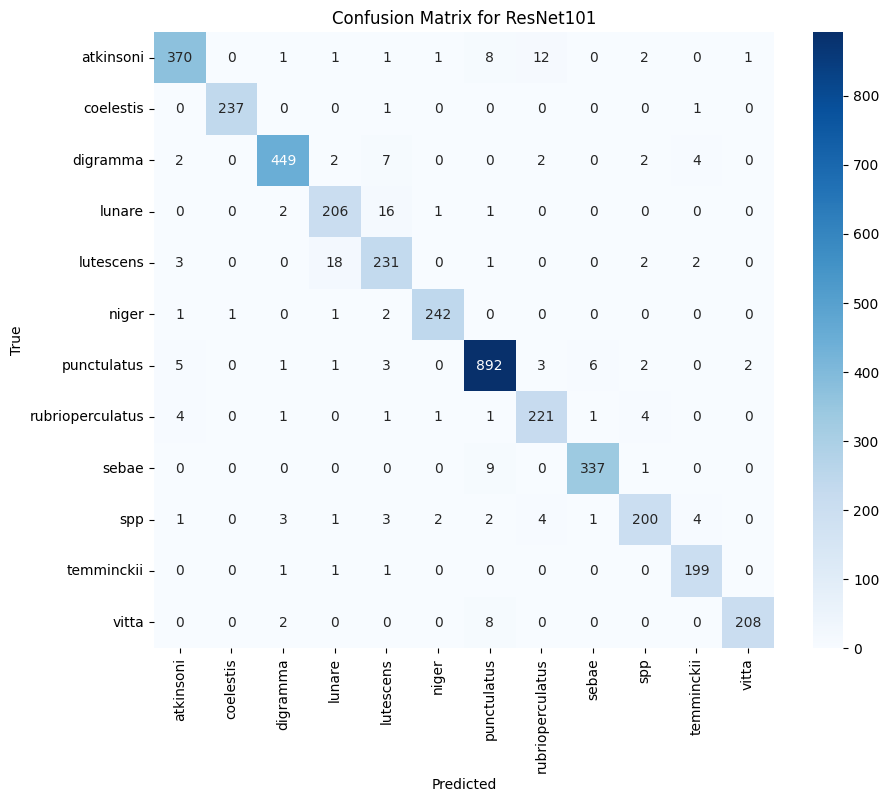


VGG19_bn:


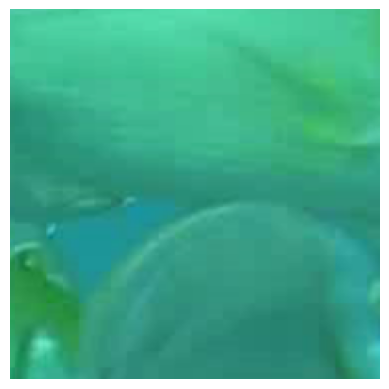

Sample 1:
Label: punctulatus
Prediction: punctulatus
Correctness: Correct


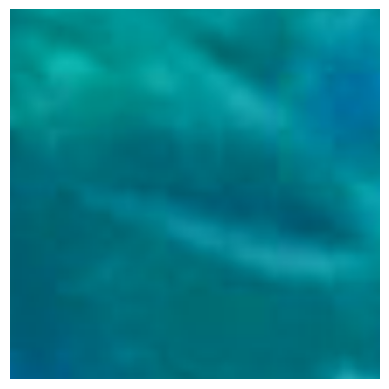

Sample 2:
Label: temminckii
Prediction: temminckii
Correctness: Correct


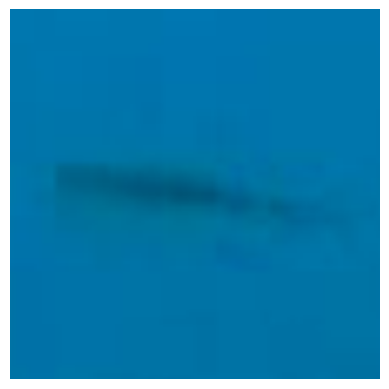

Sample 3:
Label: temminckii
Prediction: temminckii
Correctness: Correct


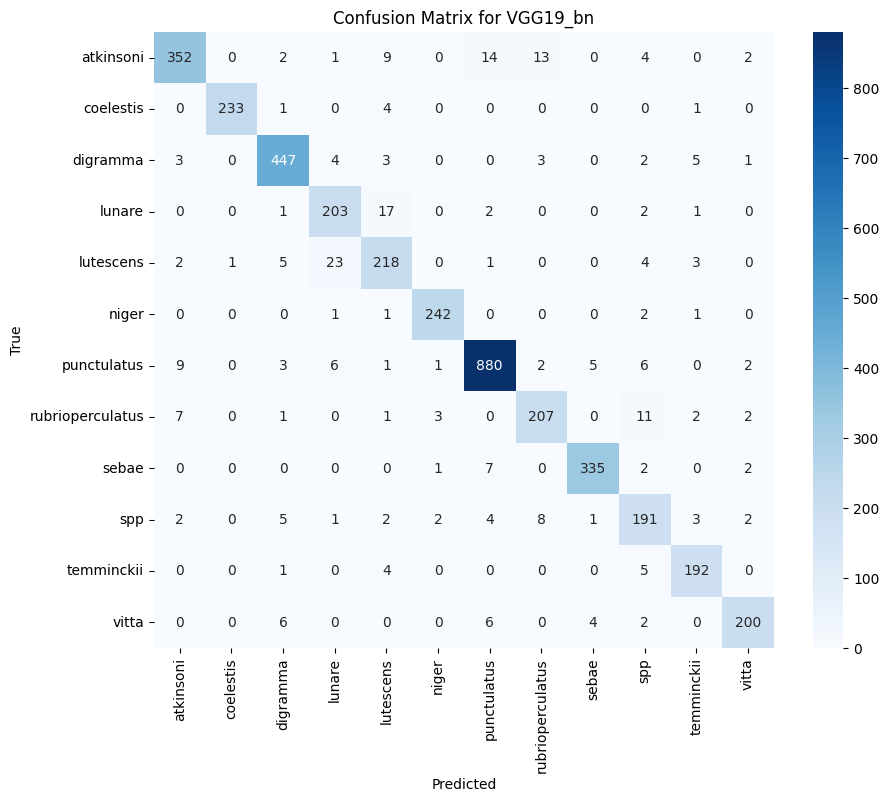

In [13]:
# With confusion matrix

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the list of model names
model_names = ['DenseNet121', 'GoogLeNet', 'ResNet101', 'VGG19_bn']
num_models = len(model_names)

# Set the number of epochs
epochs = EPOCHS

# Create a figure and adjust the spacing
fig, ax = plt.subplots(num_models, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Loop through each model
for row, model_name in enumerate(model_names):
    # Determine the index range for the current model
    start_idx = row * (epochs * 2)
    end_idx = start_idx + (epochs * 2)

    # Extract the relevant data for the current model
    train_accuracies = np.array([acc.cpu().numpy() for acc in accuracies['train'][start_idx:end_idx]])
    val_accuracies = np.array([acc.cpu().numpy() for acc in accuracies['val'][start_idx:end_idx]])
    train_losses = np.array(losses['train'][start_idx:end_idx])
    val_losses = np.array(losses['val'][start_idx:end_idx])
    epoch_list = np.arange(1, len(train_accuracies) + 1)

    # Plot the accuracy subplot
    ax[row][0].plot(epoch_list, train_accuracies, '-o', label='Train Accuracy')
    ax[row][0].plot(epoch_list, val_accuracies, '-o', label='Validation Accuracy')
    ax[row][0].axvline(epochs, color='r', linestyle='--', label='Unfreeze Net')
    ax[row][0].set_xticks(np.arange(1, len(train_accuracies) + 1, 5))
    ax[row][0].set_ylabel('Accuracy Value')
    ax[row][0].set_xlabel('Epoch')
    ax[row][0].set_title(f'Accuracy {model_name}')
    ax[row][0].legend(loc="best")

    # Plot the loss subplot
    ax[row][1].plot(epoch_list, train_losses, '-o', label='Train Loss')
    ax[row][1].plot(epoch_list, val_losses, '-o', label='Validation Loss')
    ax[row][1].axvline(epochs, color='r', linestyle='--', label='Unfreeze Net')
    ax[row][1].set_xticks(np.arange(1, len(train_losses) + 1, 5))
    ax[row][1].set_ylabel('Loss Value')
    ax[row][1].set_xlabel('Epoch')
    ax[row][1].set_title(f'Loss {model_name}')
    ax[row][1].legend(loc="best")

# Adjust the layout and display the figure
fig.tight_layout()

# Print a sample of the data with labels, predictions, and correctness
print("\nSample of the data with labels, predictions, and correctness:")
for model, model_name in zip(models_list, model_names):
    model.eval()
    y_true = []
    y_pred = []
    sample_count = 0
    with torch.no_grad():
        print(f"\n{model_name}:")
        for inputs, labels in test_loader: #TODO change back to test_loader
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(len(inputs)):
                label = dataset.classes[labels[i].cpu().numpy()]
                prediction = dataset.classes[preds[i].cpu().numpy()]
                correct = "Correct" if preds[i].cpu().numpy() == labels[i].cpu().numpy() else "Incorrect"
                # print(f"Sample {sample_count + 1}:")
                # print(f"Label: {label}")
                # print(f"Prediction: {prediction}")
                # print(f"Correctness: {correct}")

                # Print the sampled image
                if sample_count < 3:
                    image = inputs[i].cpu().permute(1, 2, 0).numpy()
                    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255.0
                    image = image.astype(np.uint8)
                    plt.figure()
                    plt.imshow(image)
                    plt.axis('off')
                    plt.show()
                    print(f"Sample {sample_count + 1}:")
                    print(f"Label: {label}")
                    print(f"Prediction: {prediction}")
                    print(f"Correctness: {correct}")

                y_true.append(labels[i].cpu().numpy())
                y_pred.append(preds[i].cpu().numpy())

                sample_count += 1
                if sample_count == 3:
                    break

        # Print the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

plt.show()